Load external libs

In [1]:
from pathlib import Path

import numpy as np
from numpy.lib.stride_tricks import as_strided
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from skimage.util import view_as_windows, pad

from applications import UNet

%matplotlib inline

Using TensorFlow backend.


load test files for evaluation

In [2]:
test_image_paths = Path('/root/input/AerialImageDataset/test/images/').glob('./*.tif')

define image util func

In [3]:
def show_img(img: np.ndarray):
    plt.figure(figsize=(6, 6))
    imshow(img)

load test image

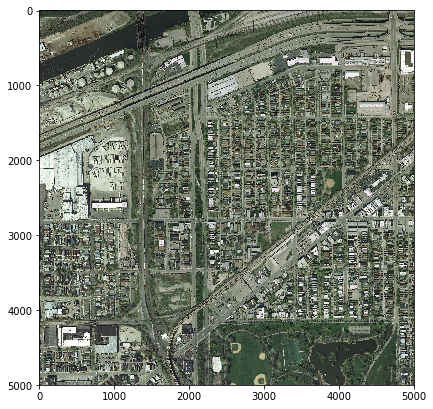

In [4]:
test_image_path = next(test_image_paths)
test_image = imread(test_image_path.as_posix())
show_img(test_image)

load trained model

In [5]:
weight_path = Path('/root/output/unet_bin_epoch100/weights_100.h5')
model = UNet(weight_path.as_posix(), batch_normalize=True)

Instructions for updating:
Colocations handled automatically by placer.


load constants from patch size to extract half center region of patch image for prediction value

In [6]:
patch_size = 256
half_patch_size = patch_size // 2
image_size = test_image.shape[0]
patch_count = image_size // half_patch_size + 1
pad_size = (patch_count + 1) * half_patch_size - image_size
half_pad_size = pad_size // 2

pad test image in symmetric mode

In [7]:
padded_test_image = pad(test_image, ((half_pad_size,half_pad_size), (half_pad_size,half_pad_size), (0,0)), 'symmetric')
padded_test_image.shape

(5248, 5248, 3)

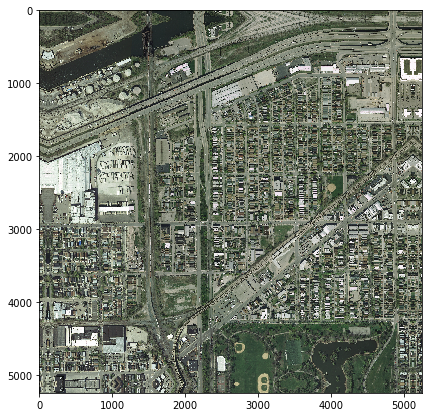

In [8]:
show_img(padded_test_image)

generate patches with stride of half patch size

In [9]:
patches = view_as_windows(padded_test_image, (patch_size, patch_size, 3), step=half_patch_size)
patches.shape

(40, 40, 1, 256, 256, 3)

concat patch axis

In [10]:
re_patches = patches.reshape((patch_count * patch_count, patch_size, patch_size, 3))
re_patches.shape

(1600, 256, 256, 3)

predict for concatted patches

In [11]:
predicted_patches = model.predict(re_patches / 255., batch_size=8)
predicted_patches.shape

(1600, 256, 256, 2)

reshape patch axis

In [12]:
re_predicted_patches = predicted_patches.reshape((patch_count, patch_count, patch_size, patch_size, 2))
re_predicted_patches.shape

(40, 40, 256, 256, 2)

use center of prediction as an output

In [13]:
center_slice = slice(half_patch_size // 2, half_patch_size // 2 + half_patch_size)
center_predicted_patches = \
re_predicted_patches[:,:,center_slice,center_slice,:]
center_predicted_patches.shape

(40, 40, 128, 128, 2)

concat prediction patches to make whole prediction output 

In [14]:
predict_one_hot = np.concatenate(
    np.concatenate(center_predicted_patches, axis=1).transpose((0, 2, 1, 3))
).transpose((1, 0, 2))
predict_one_hot.shape

(5120, 5120, 2)

show prediction output

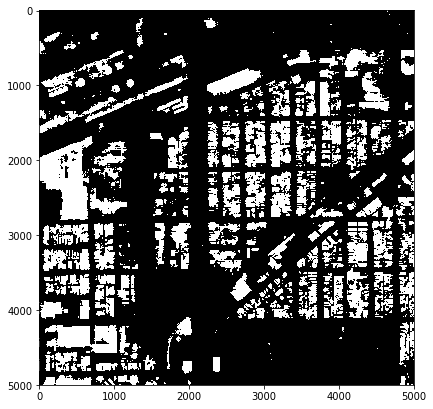

In [15]:
original_slice = slice(half_pad_size // 2, half_pad_size // 2 + 5000)
predict_bin_image = predict_one_hot[original_slice,original_slice, 1] > 0.5
show_img(predict_bin_image)

show gt output

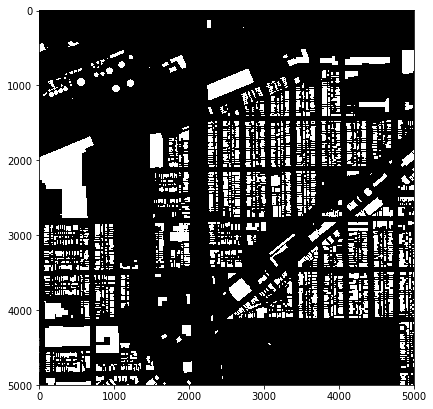

In [16]:
gt_image_path = test_image_path.parent.parent.joinpath('gt', test_image_path.name)
gt_image = imread(gt_image_path.as_posix())
gt_bin_image = gt_image > 128
show_img(gt_bin_image)

calculate intersection over union

In [17]:
overlap = predict_bin_image * gt_bin_image
union = predict_bin_image + gt_bin_image
iou = overlap.sum() / float(union.sum())
iou

0.490096584746043